In [1]:
%matplotlib inline

In [2]:
import sys
import os
aps_path = os.path.dirname(os.path.abspath("."))
if aps_path not in sys.path:
    sys.path.append(aps_path)
print(aps_path, sys.path)

D:\Dev\APS\aps ['', 'C:\\Anaconda3\\python36.zip', 'C:\\Anaconda3\\DLLs', 'C:\\Anaconda3\\lib', 'C:\\Anaconda3', 'C:\\Anaconda3\\lib\\site-packages', 'C:\\Anaconda3\\lib\\site-packages\\Sphinx-1.5.1-py3.6.egg', 'C:\\Anaconda3\\lib\\site-packages\\win32', 'C:\\Anaconda3\\lib\\site-packages\\win32\\lib', 'C:\\Anaconda3\\lib\\site-packages\\Pythonwin', 'C:\\Anaconda3\\lib\\site-packages\\IPython\\extensions', 'C:\\Users\\kmu\\.ipython', 'D:\\Dev\\APS\\aps']


In [3]:
import matplotlib.pyplot as plt
import numpy as np

import aps_io.get_arome as ga
from load_region import load_region, clip_region

In [4]:
ncfile = r"\\hdata\grid\metdata\prognosis\meps\det\archive\2019\meps_det_extracted_1km_20190223T18Z.nc"
jd, altitude, land_area_fraction, nc_vars = ga.nc_load(ncfile, ["altitude_of_0_degree_isotherm"], time_period=[6, 25])
#jd, altitude, land_area_fraction, nc_vars = ga.nc_load(ncfile, ["altitude_of_0_degree_isotherm", "altitude_of_isoTprimW_equal_0"], time_period=[18, 43])

### DIMENSIONS ###
OrderedDict([('time', <class 'netCDF4._netCDF4.Dimension'> (unlimited): name = 'time', size = 67
), ('height0', <class 'netCDF4._netCDF4.Dimension'>: name = 'height0', size = 1
), ('isotherm_0C_level', <class 'netCDF4._netCDF4.Dimension'>: name = 'isotherm_0C_level', size = 1
), ('x', <class 'netCDF4._netCDF4.Dimension'>: name = 'x', size = 1195
), ('y', <class 'netCDF4._netCDF4.Dimension'>: name = 'y', size = 1550
)])
-	time
-	height0
-	isotherm_0C_level
-	x
-	y
### VARIABLES ###
-	time
-	forecast_reference_time
-	height0
-	isotherm_0C_level
-	x
-	y
-	altitude_of_0_degree_isotherm
-	integral_of_surface_net_downward_shortwave_flux_wrt_time
-	projection_utm
-	lon
-	lat
Variable 'altitude' is not provided.
Variable 'land_area_fraction' is not provided.


In [5]:
#plt.imshow(np.flipud(nc_vars['altitude_of_0_degree_isotherm'][6, :, :]))

## Calculating the freezing level

We use the parameters "altitude_of_0_degree_isotherm" and "altitude_of_isoTprimW_equal_0" from [MEPS_extracted](http://thredds.met.no/thredds/catalog/meps25files/catalog.html).
Under dry conditions we use altitude_of_0_degree_isotherm and for timing we use the period with the highest values. With precipitation we use altitude_of_isoTprimW_equal_0 and the period with the highest amount of precipitation.

- split data into four chunks: 0-6, 6-12, 12-18, 18-24
- compress time dimension to 1 by keeping only the maximum value in each cell for each chunk
- calculate the 90-percentile for all max-values within a region
- round 90-percentile for each region to the next 50 m

### Compress time dimension

In [6]:
fl_max = np.amax(nc_vars['altitude_of_0_degree_isotherm'][0:6,:,:], axis=0)
fl_max

masked_array(
  data=[[2548.376708984375, 2550.001708984375, 2550.001708984375, ...,
         211.01388549804688, 211.01388549804688, 211.01388549804688],
        [2540.876708984375, 2542.314208984375, 2542.314208984375, ...,
         211.01388549804688, 211.01388549804688, 211.01388549804688],
        [2540.876708984375, 2542.314208984375, 2542.314208984375, ...,
         211.01388549804688, 211.01388549804688, 211.01388549804688],
        ...,
        [685.3765869140625, 685.3765869140625, 690.8140869140625, ...,
         896.7574462890625, 896.7574462890625, 897.5074462890625],
        [685.3765869140625, 684.9390869140625, 689.8140869140625, ...,
         896.7574462890625, 896.7574462890625, 897.5074462890625],
        [684.9390869140625, 684.9390869140625, 689.8140869140625, ...,
         896.9449462890625, 896.9449462890625, 898.9449462890625]],
  mask=[[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False

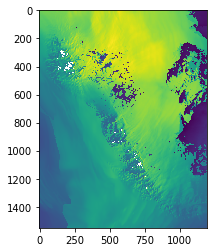

In [7]:
plt.imshow(fl_max)

### Extract regions


In [20]:
# Load region mask - only for data on 1km xgeo-grid
region_mask, y_min, y_max, x_min, x_max = load_region(3013)
print(y_max-y_min, x_max-x_min)

124 93


[False  True]


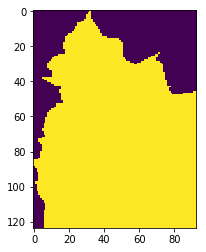

In [21]:
print(np.unique(region_mask))
plt.imshow(region_mask)

In [22]:
t_index = 0
fl_3034 = clip_region(np.flipud(fl_max), region_mask, t_index, y_min, y_max, x_min, x_max)
#print(np.unique(fl_3034))

0
[0.0 1035.3765869140625 1043.823974609375 ... 2778.064208984375
 2788.626708984375 --]


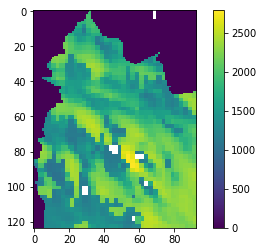

In [24]:
#fl_3034.masked_where(fl_3034<=0.0)
print(np.count_nonzero(np.isnan(fl_3034)))
print(np.unique(fl_3034))
plt.imshow(fl_3034)
plt.colorbar()

In [ ]:
print("Mean\t: ", np.nanmean(fl_3034.flatten()))
for p in [0,5,25,50,75, 80, 85,90, 95,100]:
    print(p, "\t: ", np.nanpercentile(fl_3034.flatten(), p))

In [ ]:
import seaborn as sns

In [ ]:
sns.kdeplot(fl_3034.flatten())

In [ ]:
print(fl_3034.flatten())